In [1]:
from tokenizer import Tokenizer
from data_layer import make_loader
from encoder import ConvRowEncoder, ConvEncoder
from decoder import LSTMDecoder
from model import Im2Latex
from trainer import Trainer
from utils import clean_csvs
import pandas as pd
from IPython.display import display, Math
import matplotlib.pyplot as plt
import torch

2025-11-14 08:08:50.019270: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 08:08:50.043956: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#clean_csvs()

# Tokenizer

In [3]:
df = pd.read_csv('../data/im2latex_formulas.norm.csv')
formulas = df['formulas'].tolist()

In [4]:
tokenizer = Tokenizer()
tokenizer.build_vocab(formulas)
print('Vocab size:', tokenizer.vocab_size)

Vocab size: 532


In [5]:
s = formulas[0]
ids = tokenizer.encode(s)
display('Original seq', Math(s))
print('ids:', ids)
display('Decoded seq', Math(tokenizer.decode(ids)))

'Original seq'

<IPython.core.display.Math object>

ids: [1, 70, 6, 5, 12, 100, 4, 7, 5, 118, 4, 24, 40, 159, 59, 5, 29, 4, 7, 5, 12, 40, 146, 4, 70, 6, 5, 12, 100, 4, 7, 5, 118, 4, 24, 40, 7, 5, 48, 4, 59, 5, 29, 4, 7, 5, 12, 40, 7, 5, 48, 4, 146, 4, 40, 40, 7, 5, 48, 4, 5, 16, 5, 40, 7, 5, 48, 4, 12, 40, 4, 5, 40, 15, 40, 7, 5, 48, 4, 4, 4, 113, 35, 25, 64, 7, 5, 48, 48, 4, 8, 40, 9, 12, 5, 16, 5, 35, 4, 5, 44, 4, 4, 36, 25, 64, 8, 40, 9, 119, 13, 19, 23, 2]


'Decoded seq'

<IPython.core.display.Math object>

# Data Layer

In [6]:
train_loader = make_loader(
  csv_path = '../data/cleaned_train.csv',
  root_dir = '../data/images',
  tokenizer = tokenizer,
  batch_size = 16,
  shuffle = True,
  img_height = 64
)

val_loader = make_loader(
  csv_path = '../data/cleaned_val.csv',
  root_dir = '../data/images',
  tokenizer = tokenizer,
  batch_size = 16,
  shuffle = True,
  img_height = 64
)

test_loader = make_loader(
  csv_path = '../data/cleaned_test.csv',
  root_dir = '../data/images',
  tokenizer = tokenizer,
  batch_size = 16,
  shuffle = True,
  img_height = 64
)

In [7]:
# Take a couple of batches and inspect
for i, batch in enumerate(train_loader):
    images = batch["images"]
    print(f"batch {i}: images.shape = {images.shape}")
    if i == 3:
        break


batch 0: images.shape = torch.Size([16, 1, 64, 960])
batch 1: images.shape = torch.Size([16, 1, 64, 640])
batch 2: images.shape = torch.Size([16, 1, 64, 768])
batch 3: images.shape = torch.Size([16, 1, 64, 960])


In [8]:
batch = next(iter(train_loader))

In [9]:
def visualize_batch(batch, tokenizer, max_items=10):
    images      = batch["images"]
    input_ids   = batch["input_ids"]
    target_ids  = batch["target_ids"]
    formulas    = batch["formulas"]

    B = images.shape[0]
    n = min(B, max_items)

    pad_id = tokenizer.token2id[tokenizer.pad_token]

    def strip_pad(seq):
        if pad_id in seq:
            return seq[:seq.index(pad_id)]
        return seq

    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(n):
        img = images[i].squeeze(0).cpu().numpy()

        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Item {i}")

    plt.suptitle("Batch Images")
    plt.tight_layout()
    plt.show()

    for i in range(n):
        in_ids_list  = strip_pad(input_ids[i].cpu().tolist())
        tgt_ids_list = strip_pad(target_ids[i].cpu().tolist())

        decoded_in   = tokenizer.decode(in_ids_list, remove_special=True)
        decoded_tgt  = tokenizer.decode(tgt_ids_list, remove_special=True)

        print("\n==============================")
        print(f"Item {i}")
        print("Formula:         ", formulas[i])
        print("Input IDs:       ", in_ids_list)
        print("Decoded input:   ", decoded_in)
        print("Target IDs:      ", tgt_ids_list)
        print("Decoded target:  ", decoded_tgt)
    print("==============================\n")


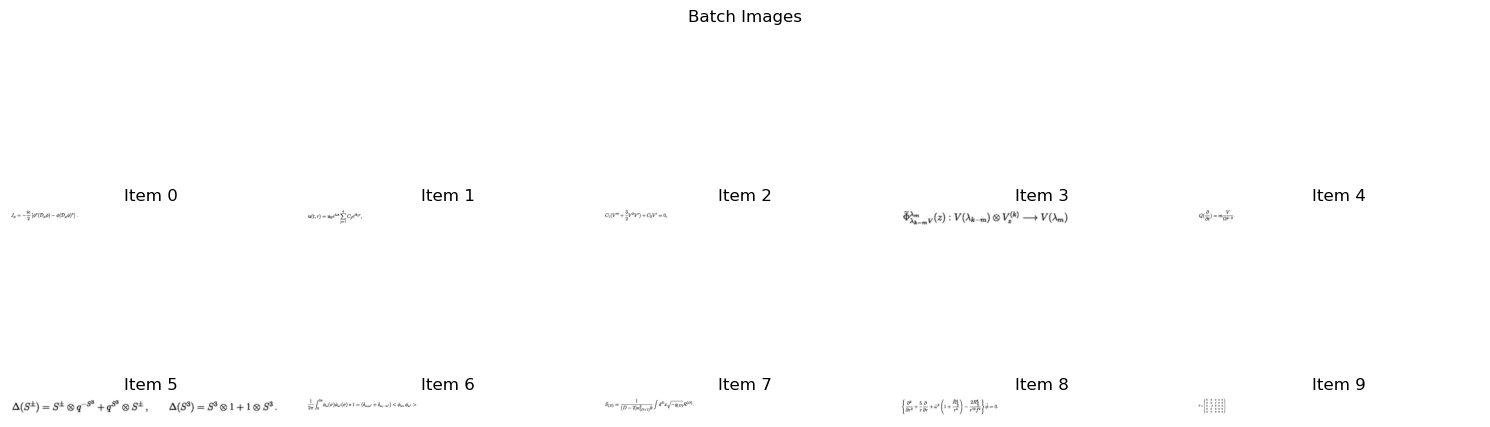


Item 0
Formula:          J _ { \mu } = - { \frac { i e } { 2 } } \left[ \phi ^ { * } ( { \cal D } _ { \mu } \phi ) - \phi ( { \cal D } _ { \mu } \phi ) ^ { * } \right] \, .
Input IDs:        [1, 102, 6, 5, 26, 4, 13, 12, 5, 16, 5, 18, 29, 4, 5, 10, 4, 4, 27, 50, 57, 7, 5, 110, 4, 8, 5, 62, 72, 4, 6, 5, 26, 4, 57, 9, 12, 57, 8, 5, 62, 72, 4, 6, 5, 26, 4, 57, 9, 7, 5, 110, 4, 28, 49, 25, 23]
Decoded input:    J_{\mu}=-{\frac{ie}{2}}\left[\phi^{*}({\calD}_{\mu}\phi)-\phi({\calD}_{\mu}\phi)^{*}\right]\,.
Target IDs:       [102, 6, 5, 26, 4, 13, 12, 5, 16, 5, 18, 29, 4, 5, 10, 4, 4, 27, 50, 57, 7, 5, 110, 4, 8, 5, 62, 72, 4, 6, 5, 26, 4, 57, 9, 12, 57, 8, 5, 62, 72, 4, 6, 5, 26, 4, 57, 9, 7, 5, 110, 4, 28, 49, 25, 23, 2]
Decoded target:   J_{\mu}=-{\frac{ie}{2}}\left[\phi^{*}({\calD}_{\mu}\phi)-\phi({\calD}_{\mu}\phi)^{*}\right]\,.

Item 1
Formula:          { \bf u } ( t , r ) = { \bf u } _ { 0 } e ^ { i \omega t } \sum _ { j = 1 } ^ { 4 } C _ { j } e ^ { i k _ { j } r } ,
Input IDs:      

In [10]:
visualize_batch(batch, tokenizer, max_items = 10)

# CNN Encoder

In [11]:
images = batch['images']

In [25]:
def vis_enc(encoder, images = images):
  with torch.no_grad():
    feat = encoder.encoder(images)
    out = encoder(images)
  B, C, Hp, Wp = feat.shape
  print(f'CNN feat: {feat.shape}\nenc_out: {out.shape}')

  plt.figure(figsize = (8, 4))
  plt.imshow(images[0].squeeze(0), cmap = 'gray')
  plt.show()

  plt.figure(figsize = (8, 4))
  plt.imshow(feat[0].mean(dim = 0), cmap = 'viridis')
  plt.colorbar()
  plt.show()

  norms = out[0].norm(dim = 1)
  norms_2d = norms.view(Hp, Wp)

  plt.figure(figsize = (8, 4))
  plt.imshow(norms_2d, cmap = 'viridis')
  plt.colorbar()
  plt.show()

In [ ]:
#enc = ConvEncoder(256)
enc = ConvRowEncoder(256)

CNN feat: torch.Size([20, 512, 16, 160])
enc_out: torch.Size([20, 2560, 512])


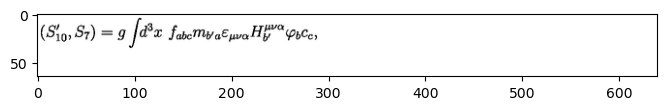

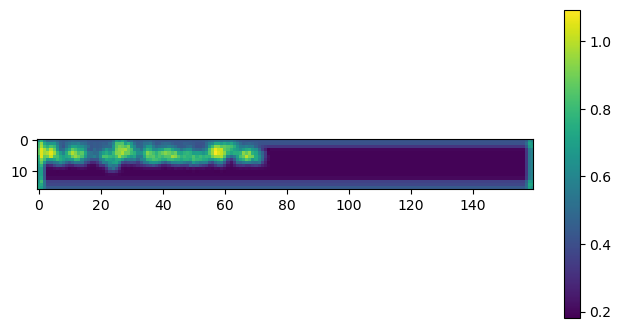

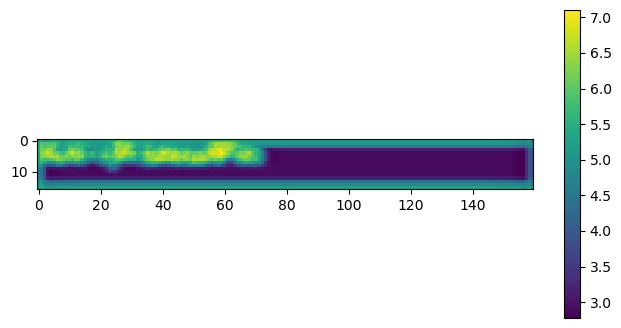

In [55]:
vis_enc(enc, images)

# Unidirectional LSTM

# Final Model

In [12]:
vocab_size = tokenizer.vocab_size
pad_id = tokenizer.token2id[tokenizer.pad_token]
sos_id = tokenizer.token2id[tokenizer.start_token]
eos_id = tokenizer.token2id[tokenizer.end_token]

model = Im2Latex(
  encoder_type = 'exp',
  vocab_size=vocab_size,
  attn_size = 128
)

In [13]:
print(model)

Im2Latex(
  (encoder): ConvEncoder1D(
    (cnn): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

# Train model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainer = Trainer(
  model = model,
  train_loader = train_loader,
  val_loader = val_loader,
  pad_id = pad_id,
  device = device,
  lr = 1e-3,
  log_dir = './runs/exp1',
  ckpt_dir = './checkpoints/exp1',
  ckpt_name = 'best.pt',
  patience = 5,
  log_interval = 20,
)


[Trainer] Starting from scratch


In [ ]:
trainer.train()

[Trainer] Starting training

Epoch 1/10


# Evaluation

In [14]:
import math
from collections import Counter
from typing import List, Dict, Any

import torch
from torch import nn
from torch.utils.data import DataLoader


# ---------- Helper functions: BLEU + edit distance ----------

def _extract_ngrams(tokens, n: int) -> Counter:
    """
    tokens: list[int] or list[str]
    returns Counter of n-grams (tuples)
    """
    return Counter(
        tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)
    )


def compute_corpus_bleu(
    references: List[List[int]],  # one ref per hypothesis
    hypotheses: List[List[int]],
    max_n: int = 4,
    smooth_eps: float = 1e-9,
) -> float:
    """
    Simplified corpus BLEU (single reference per hypothesis).

    Args:
        references: list of reference token id lists
        hypotheses: list of predicted token id lists
        max_n: up to which n-gram to use (4 = BLEU-4)
        smooth_eps: small constant for smoothing

    Returns:
        BLEU score in [0,1]
    """
    assert len(references) == len(hypotheses)
    N = max_n

    matches_by_order = [0] * N
    possible_by_order = [0] * N

    ref_length = 0
    hyp_length = 0

    for ref, hyp in zip(references, hypotheses):
        ref_length += len(ref)
        hyp_length += len(hyp)

        for n in range(1, N + 1):
            ref_ngrams = _extract_ngrams(ref, n)
            hyp_ngrams = _extract_ngrams(hyp, n)

            if len(hyp_ngrams) == 0:
                continue

            overlap = {
                ng: min(count, ref_ngrams.get(ng, 0))
                for ng, count in hyp_ngrams.items()
            }

            matches_by_order[n - 1] += sum(overlap.values())
            possible_by_order[n - 1] += max(len(hyp) - n + 1, 0)

    precisions = []
    for i in range(N):
        if possible_by_order[i] == 0:
            precisions.append(0.0)
        else:
            precisions.append(
                (matches_by_order[i] + smooth_eps)
                / (possible_by_order[i] + smooth_eps)
            )

    if max(precisions) > 0:
        log_prec_sum = sum((1.0 / N) * math.log(p) for p in precisions)
        geo_mean = math.exp(log_prec_sum)
    else:
        geo_mean = 0.0

    if hyp_length == 0:
        return 0.0

    # brevity penalty
    bp = 1.0
    if hyp_length < ref_length:
        bp = math.exp(1.0 - float(ref_length) / float(hyp_length))

    bleu = bp * geo_mean
    return bleu


def levenshtein_distance(ref: List[int], hyp: List[int]) -> int:
    """
    Token-level Levenshtein distance between two lists.
    ref, hyp: list[int] or list[str]
    """
    n = len(ref)
    m = len(hyp)

    if n == 0:
        return m
    if m == 0:
        return n

    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if ref[i - 1] == hyp[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,          # deletion
                dp[i][j - 1] + 1,          # insertion
                dp[i - 1][j - 1] + cost,   # substitution
            )
    return dp[n][m]


# ---------- ModelEvaluator class ----------

class ModelEvaluator:
    """
    Evaluator for Im2Latex model.

    Computes:
      - average CE loss
      - token-level accuracy (ignoring PAD)
      - sequence-level exact match rate
      - corpus BLEU-4 (token-based)
      - average normalized token-level edit distance

    Also prints a few GT vs PRED LaTeX examples.
    """

    def __init__(
        self,
        model: nn.Module,
        tokenizer,
        pad_id: int,
        sos_id: int,
        eos_id: int,
        device: torch.device,
        max_len: int = 150,
        print_samples: int = 5,
    ):
        """
        Args:
            model: trained Im2Latex model (with .greedy_decode)
            tokenizer: your tokenizer with .decode(ids, remove_special=True)
            pad_id: <pad> id
            sos_id: <sos> id
            eos_id: <eos> id
            device: torch.device
            max_len: max decoding length for greedy_decode
            print_samples: number of GT/PRED pairs to print
        """
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.pad_id = pad_id
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.device = device
        self.max_len = max_len
        self.print_samples = print_samples

        self.ce_loss = nn.CrossEntropyLoss(ignore_index=self.pad_id)

    @torch.no_grad()
    def evaluate(self, data_loader: DataLoader) -> Dict[str, Any]:
        """
        Run evaluation on a DataLoader (e.g. test_loader).

        Returns dict with:
          - "loss"
          - "token_acc"
          - "seq_exact"
          - "bleu4"
          - "avg_norm_edit"
        """
        self.model.eval()

        total_loss = 0.0
        total_batches = 0

        total_tokens = 0
        total_correct_tokens = 0

        total_sequences = 0
        total_exact_match = 0

        printed = 0

        all_refs_tokens: List[List[int]] = []
        all_hyps_tokens: List[List[int]] = []
        norm_edit_sum = 0.0

        for batch in data_loader:
            images = batch["images"].to(self.device)         # (B, C, H, W)
            input_ids = batch["input_ids"].to(self.device)   # (B, T) decoder input
            target_ids = batch["target_ids"].to(self.device) # (B, T) decoder target

            # --- loss & token accuracy ---
            logits, _ = self.model(
                images=images,
                tgt_ids=input_ids,
                mem_pad=None,
                need_xattn=False,
            )  # (B,T,V)

            B, T, V = logits.shape
            loss = self.ce_loss(
                logits.view(B * T, V),
                target_ids.view(B * T),
            )
            total_loss += loss.item()
            total_batches += 1

            pred_tokens = logits.argmax(dim=-1)  # (B,T)
            mask = (target_ids != self.pad_id)   # (B,T)
            correct = (pred_tokens == target_ids) & mask

            total_correct_tokens += correct.sum().item()
            total_tokens += mask.sum().item()

            # --- sequence-level metrics (greedy decode) ---
            pred_ids = self.model.greedy_decode(
                images,
                sos_id=self.sos_id,
                eos_id=self.eos_id,
                max_len=self.max_len,
                mem_pad=None,
            )  # (B, L_pred)

            for b in range(B):
                # reference: strip PAD, cut at EOS
                ref_seq = target_ids[b].tolist()
                ref_seq = [tok for tok in ref_seq if tok != self.pad_id]
                if self.eos_id in ref_seq:
                    ref_seq = ref_seq[: ref_seq.index(self.eos_id) + 1]

                # prediction: cut at EOS
                hyp_seq = pred_ids[b].tolist()
                if self.eos_id in hyp_seq:
                    hyp_seq = hyp_seq[: hyp_seq.index(self.eos_id) + 1]

                all_refs_tokens.append(ref_seq)
                all_hyps_tokens.append(hyp_seq)

                # normalized token-level edit distance
                if len(ref_seq) > 0:
                    dist = levenshtein_distance(ref_seq, hyp_seq)
                    norm_edit_sum += dist / len(ref_seq)
                else:
                    norm_edit_sum += 0.0

                # decode to strings for exact match + printing
                ref_str = self.tokenizer.decode(ref_seq, remove_special=True)
                pred_str = self.tokenizer.decode(hyp_seq, remove_special=True)

                total_sequences += 1
                if pred_str == ref_str:
                    total_exact_match += 1

                if printed < self.print_samples:
                    print("---- Sample", printed + 1, "----")
                    print("GT:   ", ref_str)
                    print("PRED: ", pred_str)
                    print()
                    printed += 1

        avg_loss = total_loss / max(1, total_batches)
        token_acc = total_correct_tokens / max(1, total_tokens)
        seq_exact = total_exact_match / max(1, total_sequences)
        avg_norm_edit = norm_edit_sum / max(1, total_sequences)

        bleu4 = compute_corpus_bleu(
            references=all_refs_tokens,
            hypotheses=all_hyps_tokens,
            max_n=4,
        )

        print("====== Evaluation ======")
        print(f"Avg loss:                  {avg_loss:.4f}")
        print(f"Token accuracy:            {token_acc*100:.2f}%")
        print(f"Seq exact match:           {seq_exact*100:.2f}%")
        print(f"Corpus BLEU-4 (tokens):    {bleu4*100:.2f}%")
        print(f"Avg normalized edit dist:  {avg_norm_edit:.4f}")
        print("=========================")

        return {
            "loss": avg_loss,
            "token_acc": token_acc,
            "seq_exact": seq_exact,
            "bleu4": bleu4,
            "avg_norm_edit": avg_norm_edit,
        }


In [15]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
ckpt = torch.load('./checkpoints/exp1/best4.pt', map_location='cpu')
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [16]:
model.eval()

pad_id = tokenizer.token2id[tokenizer.pad_token]
sos_id = tokenizer.token2id[tokenizer.start_token]
eos_id = tokenizer.token2id[tokenizer.end_token]

evaluator = ModelEvaluator(
    model=model,
    tokenizer=tokenizer,
    pad_id=tokenizer.token2id[tokenizer.pad_token],
    sos_id=tokenizer.token2id[tokenizer.start_token],
    eos_id=tokenizer.token2id[tokenizer.end_token],
    device='cpu',
    max_len=512,
    print_samples=5,
)

metrics = evaluator.evaluate(test_loader)
print(metrics)

No text was foundNo text was found

No text was found
No text was found
---- Sample 1 ----
GT:    \left\{M_{\mu\nu},\phi(k)\right\}=D_{\mu\nu}\phi(k),
PRED:  \{M_{\mu\nu},\phi(k)\}=D_{\mu\nu}\phi(k),

---- Sample 2 ----
GT:    b\left(x\right)=\chi\xi_{1}C_{1}e^{-x\xi_{1}}-\chi\overline{{\xi}}
PRED:  b\left(x\right)=\chi\xi_{1}C_{1}e^{-x\xi_{1}}-\chi\widetilde{\xi}

---- Sample 3 ----
GT:    C=\left(\begin{array}{ll}{<E_{x}^{*}E_{x}>}&{<E_{y}^{*}E_{x}>}\\{<E_{x}^{*}E_{y}>}&{<E_{y}^{*}E_{y}>}\\\end{array}\right),
PRED:  C=\left(<E_{x}^{\mu_{s}E_{y}}>\ \ <E_{y}^{y}E_{y}>\right),

---- Sample 4 ----
GT:    X^{\mu}=Y_{1}^{\mu}+{\frac{Y_{2}^{\mu}-Y_{1}^{\mu}}{\pi}}\sigma+\sqrt{2\alpha^{\prime}}\sum_{n}{\frac{a_{n}^{\mu}}{n}}e^{-in\tau}\operatorname{sin}(n\sigma).
PRED:  X^{\mu}=Y_{1}^{\mu}+\frac{Y_{1}^{\mu}-Y_{1}^{\mu}}{\pi}\sigma+\sqrt{2\alpha^{\prime}}\sum_{n}\frac{a_{\mu}^{\mu}}{n}e^{-in\tau}\operatorname{sin}(n\sigma).

---- Sample 5 ----
GT:    T=\zeta\omega[\psi_{2},\psi_{1}]+\frac{\im

KeyboardInterrupt: 

In [18]:
test = Tokenizer.load('./vocab.json')
test.vocab_size

532